 Example.jl









 Paul.Soderlind@unisg.ch, April 2002, to Julia Nov 2015

In [1]:
using Optim

include("BondPricePs.jl")
include("BondNSxPs.jl")


ytmLoss  = 0           #0: mimimize squared price errors: 1: minimize squared ytm errors
  weightLoss = 1       #1: 1/mat as weights for (fitted price-price)^2 in loss fn (only if ytmLoss==0)

1

In [2]:
                                 #Swedish bond data for 29 Dec 1993

#coupons in %/yr
c  = [ 0;        0;         0;         0;         11.5;      10.75;
       11;       13;        10.25;     6;         9 ]

#time to maturity in year
tm = [ 0.00274;  0.21096;   0.46027;   0.88219;   1.67397;   3.06849;
       5.06301;  7.46027;   9.34795;   11.11507;  15.30685 ]

#interest rates.  Bills: simple rates in %/yr; bonds: yield to maturity in %/yr
y  = [ 7.75;     6.835;    6.655;     6.41;      6.215;     6.195;
       6.41;     6.755;    7.01;      7.21;      7.325 ]

11-element Array{Float64,1}:
 7.75
 6.835
 6.655
 6.41
 6.215
 6.195
 6.41
 6.755
 7.01
 7.21
 7.325

In [3]:
#transform the data

c  = c/100 # -> column vector, coupons and yields as 0.05 rather than 5
y  = y/100

vvc    = c .== 0                #if bill, change from simple to effective rate
y[vvc] = (1 .+ tm[vvc].*y[vvc]).^(1.0./tm[vvc]) .- 1

pdat = fill(NaN,length(y))         #calculate bond prices
for i = 1:length(y)
  local ti
  ti      = mod(tm[i],1):tm[i]
  pdat[i] = BondPricePs(y[i],c[i],ti)
end

In [4]:
parX0 = [0.1045;-0.03;-0.0562;1.2;0;0.5]           #starting guess
tmFig = range(1e-8,stop=maximum(tm),length=1001)   #maturities to plot
(shx,fhx,dhx) = BondNSxPs(tmFig,parX0[1],parX0[2],parX0[3],parX0[4],parX0[5],parX0[6])

println("\nImplied spot rates (test): ",round.(100*shx[[1:3;end-3:end]],digits=3))


Implied spot rates (test): [7.45, 7.434, 7.417, 9.772, 9.773, 9.774, 9.774]


In [5]:
#estimating parameters in extended Nelson&Siegel model

parX0 = [0.1045;-0.03;-0.0562;1.2;0;0.5]       #starting guess

if ytmLoss == 1
  NSXbR = BondNSxEstPs(parX0,y,tm,c,log(1+y[1]),1)
else
  if weightLoss == 1
    NSXbR = BondNSxEstPs(parX0,pdat,tm,c,log(1+y[1]),0,1.0./tm)
  else
    NSXbR = BondNSxEstPs(parX0,pdat,tm,c,log(1+y[1]))
  end
end
println("\nEstimates: ",round.(NSXbR,digits=3))


Estimates: [0.081, -0.003, -0.062, 1.634, -0.02, 0.175]


In [6]:
#calculate implied rates (spot, forward, yield to maturity) to plot

tmFig = range(1e-8,stop=maximum(tm),length=101)           #maturities to plot
(shx,fhx,dhx) = BondNSxPs(tmFig,NSXbR[1],NSXbR[2],NSXbR[3],NSXbR[4],NSXbR[5],NSXbR[6])
shx = exp.(shx) .- 1     #effective interest rate
fhx = exp.(fhx) .- 1
println("\nImplied spot rates (NSXbR): ",round.(100*shx[[1:3;end-3:end]],digits=3))

n    = length(c)
ytmx = fill(NaN,n)
for i = 1:n                #loop over bonds
  local ti,s,f,d,Qx
  ti      = mod(tm[i],1):tm[i]
  (s,f,d) = BondNSxPs(ti,NSXbR[1],NSXbR[2],NSXbR[3],NSXbR[4],NSXbR[5],NSXbR[6])
  Qx      = sum(d.*c[i]) + d[end]          #implied bond price
  #println(ti)
  ytmx[i] = BondYieldToMatPs(Qx,c[i],ti,1,1,0.05,1e-7)[1]
end
println("\nImplied ytm (NSXbR): ",round.(100*ytmx,digits=3))


Implied spot rates (NSXbR): [8.057, 7.237, 6.891, 7.612, 7.62, 7.628, 7.635]

Implied ytm (NSXbR): [8.035, 7.073, 6.718, 6.468, 6.216, 6.167, 6.439, 6.765, 6.985, 7.187, 7.346]


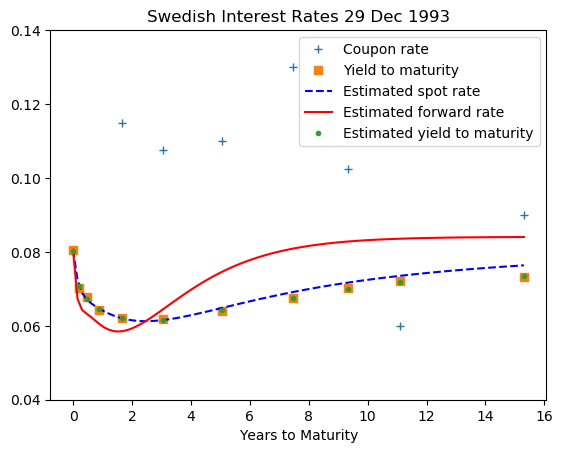

(0.04, 0.14)

In [7]:
#Comment out this if you do not have PyPlot installed.

using PyPlot
PyPlot.svg(true)           #for ipynb notebooks
close("all")
                                       #plotting
figure()
  plot(tm,c,"+",tm,y,"s",tmFig,shx,"b--",tmFig,fhx,"r-",tm,ytmx,".")
  title("Swedish Interest Rates 29 Dec 1993")
  xlabel("Years to Maturity")
  legend(["Coupon rate","Yield to maturity","Estimated spot rate",
         "Estimated forward rate","Estimated yield to maturity"],loc=1)
  ylim(0.04,0.14)
  #display(gcf())            #uncomment in Atom/Juno

In [8]:
println("done")

done


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*